# Creating A DMF Solvent Box for OpenMM using OPLS-AA
http://dx.doi.org/10.1021/ct200731v  

Meant to be used for QM/MM MD Simulations. The plan is to:

1. Create the solvent box from a single DMF where we already have a gromacs .top 
2. Equilibrate the box in NPT
3. Cut out room for the solute  
    A. Manually edit the topology and positions to remove overlapping molecules
4. Use an ASE-OpenMM interface for the QM/MM, so it is the (slow) ASE taking care of dynamics and constraints, and OpenMM just delivers forces and energies as any other ASE calculator

This notebook uses an `openmoltools` packaging of the `packmol` code. You should be able to install it with `conda install -c conda-forge -c omnia openmoltools`


In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False


import os
import sys
import matplotlib 

%matplotlib notebook
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'font.size': 14})


import numpy as np
import openmoltools  # -- needs to update to remove simtk from updates.
import mdtraj
import nglview
from copy import deepcopy
from openmm.vec3 import Vec3
from openmm import unit as u
from openmm.app import GromacsGroFile, GromacsTopFile
from openmm import app
import parmed as pmd 
from sys import stdout
from openmm import XmlSerializer

from openmm.openmm import MonteCarloBarostat, LangevinIntegrator

The `.gro` and `.top` files from gromacs need to be converted to a pdb with the right `CONECT` entries. The PDB already has them:

Load the pdb as an mdtraj: 

In [20]:
traj = mdtraj.load_pdb('../../data/md/dmf/dmf.pdb')
nglview.show_mdtraj(traj)

NGLWidget()

In [23]:
traj.n_atoms

12

Make a 512 mol box:

In [3]:
num_mols = 512
box = openmoltools.packmol.pack_box(traj[-1], [num_mols])


# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmpouvh0ws9/tmpr24knw1p.pdb
add_amber_ter


structure /tmp/tmpouvh0ws9/tmpqed4whqr.pdb
  number 512
  inside box 0. 0. 0. 74.662718 74.662718 74.662718
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 18.013 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmpouvh0ws9/tmpr24knw1p.pdb
  Reading coordinate file: /tmp/tmpouvh0ws9/tmpqed4whqr.pdb
  Number of independent structures:            1
  Th

Now onto some hackyness. Load the one-mol .top so we can get to the `createSystem` from the `GromacsTop`, but update the topology to the box topology, made by packmol. Also update box vectors in this new topology

In [4]:
box_top = box.top.to_openmm()
box_pos = box.openmm_positions(0)
bvs = tuple([Vec3(*x) * u.nanometer for x in box.unitcell_vectors[0]])


# create single molecule top, because this one can make the system:
top = GromacsTopFile('../../data/md/dmf/dmf.top', periodicBoxVectors=bvs,
        includeDir='/home/asod/Apps/gromacs/gromacs-2021.1/share/top/oplsaa.ff/')
# But then update with the box top
top.topology = deepcopy(box.top.to_openmm())
top.topology.setPeriodicBoxVectors(bvs)
top._molecules = [('NN-dimethylformamide', num_mols)]  # don't think it got the LJs for all new mols

Make the OpenMM `system`

In [5]:
box_system = top.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0 * u.nanometers, constraints=app.HBonds)
box_system.addForce(MonteCarloBarostat(1 * u.bar, 300 * u.kelvin))

8

In [5]:
nbf = box_system.getForces()[0]

<Topology; 512 chains, 512 residues, 6144 atoms, 5632 bonds>

In [7]:
sigmas = [nbf.getParticleParameters(x)[1] for x in range(nbf.getNumParticles())]

In [8]:
(np.array([x.value_in_unit(u.nanometer) for x in sigmas]) > 1).any()

False

Seems like there is no LJs in the system :(

Parse `ffnonbonded.itp` and find the atom types gromacs wants for NN-dimethylformamide

In [2]:
with open('/home/asod/Apps/gromacs/gromacs-2021.1/share/top/oplsaa.ff/ffnonbonded.itp', 'r') as f:
    itp = f.readlines()
itp = [i.split() for i in itp if 'opls_' in i]
itp_struct = {i[0]: {'sig':i[6],
                     'eps':i[7],
                     'bond_type': f'{i[1]}-{i[2]}',
                     'mass': i[3],
                     'charge': i[4]} for i in itp}
with open('../../data/md/dmf/dmf.top', 'r') as f:
    dmf = f.readlines()
dmf = [i.split() for i in dmf if 'opls_' in i]

In [3]:
from openmm import unit as u 
dmf_sigs = [float(itp_struct[d[1]]['sig']) * u.nanometer for d in dmf]
dmf_epss = [float(itp_struct[d[1]]['eps']) * u.kilojoule_per_mole for d in dmf]
dmf_chgs = [float(itp_struct[d[1]]['charge']) * u.kilojoule_per_mole for d in dmf]  # already in there

Update the system with these LJs. 

WOOPS I'm missing 1-4 scaling of OPLS.. It the scale factor seems to be 0.5:  https://pubs.acs.org/doi/pdf/10.1021/ja9621760


Not sure this current version works, it doesn't change the LJ. Check `createExceptionsFromBonds(self, bonds, coulomb14Scale, lj14Scale)` maybe, from here: http://docs.openmm.org/7.2.0/api-python/generated/simtk.openmm.openmm.NonbondedForce.html

In [5]:
sigmas = np.tile(dmf_sigs, num_mols)
epsilons = np.tile(dmf_epss, num_mols) 

In [12]:
from simtk.openmm.openmm import NonbondedForce
for force in box_system.getForces():
    if isinstance(force, NonbondedForce):
        for i in range(force.getNumParticles()):
            charge, sigma, epsilon = force.getParticleParameters(i)
            force.setParticleParameters(i, charge * u.elementary_charge,
                                        sigmas[i].in_units_of(u.nanometer),
                                        epsilons[i].in_units_of(u.kilojoule_per_mole))
            print(f'SIG: OLD: {sigma._value:9.6f}, NEW: {sigmas[i].in_units_of(u.nanometer)._value:9.6f} ' +
                  f'EPS: OLD: {epsilon._value:9.6f}, NEW: {epsilons[i].in_units_of(u.kilojoule_per_mole)._value:9.6f}' + 
                  f' Charge: {charge._value:2.4f}')
            
scale_fac = 0.5
for force in box_system.getForces():
    if isinstance(force, NonbondedForce):
        for i in range(force.getNumExceptions()):
            particle1, particle2, chargeProd, sigma, epsilon = force.getExceptionParameters(i)
            if chargeProd != 0 * u.elementary_charge**2: # Is it a 1-4 interaction?
                newChargeProd = chargeProd * scale_fac
                print(i, chargeProd, newChargeProd)

                force.setExceptionParameters(i, particle1, particle2,
                                             newChargeProd * u.elementary_charge**2, sigma, epsilon)



SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711280 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439320 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.242000 EPS: OLD:  0.000000, NEW:  0.062760 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS:

SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439320 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.242000 EPS: OLD:  0.000000, NEW:  0.062760 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878640 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711280 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS:

SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439320 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.242000 EPS: OLD:  0.000000, NEW:  0.062760 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878640 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS:

SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878640 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711280 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439320 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.242000 EPS

237 -0.0033 e**2 -0.00165 e**2
238 -0.0033 e**2 -0.00165 e**2
240 -0.0033 e**2 -0.00165 e**2
243 -0.0033 e**2 -0.00165 e**2
247 -0.0033 e**2 -0.00165 e**2
253 0.015 e**2 0.0075 e**2
254 0.015 e**2 0.0075 e**2
255 0.015 e**2 0.0075 e**2
258 0.015 e**2 0.0075 e**2
259 0.015 e**2 0.0075 e**2
260 0.015 e**2 0.0075 e**2
265 0.0275 e**2 0.01375 e**2
267 0.0275 e**2 0.01375 e**2
281 -0.0033 e**2 -0.00165 e**2
282 -0.0033 e**2 -0.00165 e**2
283 -0.0033 e**2 -0.00165 e**2
285 -0.0033 e**2 -0.00165 e**2
288 -0.0033 e**2 -0.00165 e**2
292 -0.0033 e**2 -0.00165 e**2
298 0.015 e**2 0.0075 e**2
299 0.015 e**2 0.0075 e**2
300 0.015 e**2 0.0075 e**2
303 0.015 e**2 0.0075 e**2
304 0.015 e**2 0.0075 e**2
305 0.015 e**2 0.0075 e**2
310 0.0275 e**2 0.01375 e**2
312 0.0275 e**2 0.01375 e**2
326 -0.0033 e**2 -0.00165 e**2
327 -0.0033 e**2 -0.00165 e**2
328 -0.0033 e**2 -0.00165 e**2
330 -0.0033 e**2 -0.00165 e**2
333 -0.0033 e**2 -0.00165 e**2
337 -0.0033 e**2 -0.00165 e**2
343 0.015 e**2 0.0075 e**2
344 0.

1543 -0.0033 e**2 -0.00165 e**2
1545 -0.0033 e**2 -0.00165 e**2
1548 -0.0033 e**2 -0.00165 e**2
1552 -0.0033 e**2 -0.00165 e**2
1558 0.015 e**2 0.0075 e**2
1559 0.015 e**2 0.0075 e**2
1560 0.015 e**2 0.0075 e**2
1563 0.015 e**2 0.0075 e**2
1564 0.015 e**2 0.0075 e**2
1565 0.015 e**2 0.0075 e**2
1570 0.0275 e**2 0.01375 e**2
1572 0.0275 e**2 0.01375 e**2
1586 -0.0033 e**2 -0.00165 e**2
1587 -0.0033 e**2 -0.00165 e**2
1588 -0.0033 e**2 -0.00165 e**2
1590 -0.0033 e**2 -0.00165 e**2
1593 -0.0033 e**2 -0.00165 e**2
1597 -0.0033 e**2 -0.00165 e**2
1603 0.015 e**2 0.0075 e**2
1604 0.015 e**2 0.0075 e**2
1605 0.015 e**2 0.0075 e**2
1608 0.015 e**2 0.0075 e**2
1609 0.015 e**2 0.0075 e**2
1610 0.015 e**2 0.0075 e**2
1615 0.0275 e**2 0.01375 e**2
1617 0.0275 e**2 0.01375 e**2
1631 -0.0033 e**2 -0.00165 e**2
1632 -0.0033 e**2 -0.00165 e**2
1633 -0.0033 e**2 -0.00165 e**2
1635 -0.0033 e**2 -0.00165 e**2
1638 -0.0033 e**2 -0.00165 e**2
1642 -0.0033 e**2 -0.00165 e**2
1648 0.015 e**2 0.0075 e**2
1649

2982 -0.0033 e**2 -0.00165 e**2
2983 -0.0033 e**2 -0.00165 e**2
2985 -0.0033 e**2 -0.00165 e**2
2988 -0.0033 e**2 -0.00165 e**2
2992 -0.0033 e**2 -0.00165 e**2
2998 0.015 e**2 0.0075 e**2
2999 0.015 e**2 0.0075 e**2
3000 0.015 e**2 0.0075 e**2
3003 0.015 e**2 0.0075 e**2
3004 0.015 e**2 0.0075 e**2
3005 0.015 e**2 0.0075 e**2
3010 0.0275 e**2 0.01375 e**2
3012 0.0275 e**2 0.01375 e**2
3026 -0.0033 e**2 -0.00165 e**2
3027 -0.0033 e**2 -0.00165 e**2
3028 -0.0033 e**2 -0.00165 e**2
3030 -0.0033 e**2 -0.00165 e**2
3033 -0.0033 e**2 -0.00165 e**2
3037 -0.0033 e**2 -0.00165 e**2
3043 0.015 e**2 0.0075 e**2
3044 0.015 e**2 0.0075 e**2
3045 0.015 e**2 0.0075 e**2
3048 0.015 e**2 0.0075 e**2
3049 0.015 e**2 0.0075 e**2
3050 0.015 e**2 0.0075 e**2
3055 0.0275 e**2 0.01375 e**2
3057 0.0275 e**2 0.01375 e**2
3071 -0.0033 e**2 -0.00165 e**2
3072 -0.0033 e**2 -0.00165 e**2
3073 -0.0033 e**2 -0.00165 e**2
3075 -0.0033 e**2 -0.00165 e**2
3078 -0.0033 e**2 -0.00165 e**2
3082 -0.0033 e**2 -0.00165 e**2


4530 0.015 e**2 0.0075 e**2
4533 0.015 e**2 0.0075 e**2
4534 0.015 e**2 0.0075 e**2
4535 0.015 e**2 0.0075 e**2
4540 0.0275 e**2 0.01375 e**2
4542 0.0275 e**2 0.01375 e**2
4556 -0.0033 e**2 -0.00165 e**2
4557 -0.0033 e**2 -0.00165 e**2
4558 -0.0033 e**2 -0.00165 e**2
4560 -0.0033 e**2 -0.00165 e**2
4563 -0.0033 e**2 -0.00165 e**2
4567 -0.0033 e**2 -0.00165 e**2
4573 0.015 e**2 0.0075 e**2
4574 0.015 e**2 0.0075 e**2
4575 0.015 e**2 0.0075 e**2
4578 0.015 e**2 0.0075 e**2
4579 0.015 e**2 0.0075 e**2
4580 0.015 e**2 0.0075 e**2
4585 0.0275 e**2 0.01375 e**2
4587 0.0275 e**2 0.01375 e**2
4601 -0.0033 e**2 -0.00165 e**2
4602 -0.0033 e**2 -0.00165 e**2
4603 -0.0033 e**2 -0.00165 e**2
4605 -0.0033 e**2 -0.00165 e**2
4608 -0.0033 e**2 -0.00165 e**2
4612 -0.0033 e**2 -0.00165 e**2
4618 0.015 e**2 0.0075 e**2
4619 0.015 e**2 0.0075 e**2
4620 0.015 e**2 0.0075 e**2
4623 0.015 e**2 0.0075 e**2
4624 0.015 e**2 0.0075 e**2
4625 0.015 e**2 0.0075 e**2
4630 0.0275 e**2 0.01375 e**2
4632 0.0275 e**2 0

5591 -0.0033 e**2 -0.00165 e**2
5592 -0.0033 e**2 -0.00165 e**2
5593 -0.0033 e**2 -0.00165 e**2
5595 -0.0033 e**2 -0.00165 e**2
5598 -0.0033 e**2 -0.00165 e**2
5602 -0.0033 e**2 -0.00165 e**2
5608 0.015 e**2 0.0075 e**2
5609 0.015 e**2 0.0075 e**2
5610 0.015 e**2 0.0075 e**2
5613 0.015 e**2 0.0075 e**2
5614 0.015 e**2 0.0075 e**2
5615 0.015 e**2 0.0075 e**2
5620 0.0275 e**2 0.01375 e**2
5622 0.0275 e**2 0.01375 e**2
5636 -0.0033 e**2 -0.00165 e**2
5637 -0.0033 e**2 -0.00165 e**2
5638 -0.0033 e**2 -0.00165 e**2
5640 -0.0033 e**2 -0.00165 e**2
5643 -0.0033 e**2 -0.00165 e**2
5647 -0.0033 e**2 -0.00165 e**2
5653 0.015 e**2 0.0075 e**2
5654 0.015 e**2 0.0075 e**2
5655 0.015 e**2 0.0075 e**2
5658 0.015 e**2 0.0075 e**2
5659 0.015 e**2 0.0075 e**2
5660 0.015 e**2 0.0075 e**2
5665 0.0275 e**2 0.01375 e**2
5667 0.0275 e**2 0.01375 e**2
5681 -0.0033 e**2 -0.00165 e**2
5682 -0.0033 e**2 -0.00165 e**2
5683 -0.0033 e**2 -0.00165 e**2
5685 -0.0033 e**2 -0.00165 e**2
5688 -0.0033 e**2 -0.00165 e**2


6853 -0.0033 e**2 -0.00165 e**2
6855 -0.0033 e**2 -0.00165 e**2
6858 -0.0033 e**2 -0.00165 e**2
6862 -0.0033 e**2 -0.00165 e**2
6868 0.015 e**2 0.0075 e**2
6869 0.015 e**2 0.0075 e**2
6870 0.015 e**2 0.0075 e**2
6873 0.015 e**2 0.0075 e**2
6874 0.015 e**2 0.0075 e**2
6875 0.015 e**2 0.0075 e**2
6880 0.0275 e**2 0.01375 e**2
6882 0.0275 e**2 0.01375 e**2
6896 -0.0033 e**2 -0.00165 e**2
6897 -0.0033 e**2 -0.00165 e**2
6898 -0.0033 e**2 -0.00165 e**2
6900 -0.0033 e**2 -0.00165 e**2
6903 -0.0033 e**2 -0.00165 e**2
6907 -0.0033 e**2 -0.00165 e**2
6913 0.015 e**2 0.0075 e**2
6914 0.015 e**2 0.0075 e**2
6915 0.015 e**2 0.0075 e**2
6918 0.015 e**2 0.0075 e**2
6919 0.015 e**2 0.0075 e**2
6920 0.015 e**2 0.0075 e**2
6925 0.0275 e**2 0.01375 e**2
6927 0.0275 e**2 0.01375 e**2
6941 -0.0033 e**2 -0.00165 e**2
6942 -0.0033 e**2 -0.00165 e**2
6943 -0.0033 e**2 -0.00165 e**2
6945 -0.0033 e**2 -0.00165 e**2
6948 -0.0033 e**2 -0.00165 e**2
6952 -0.0033 e**2 -0.00165 e**2
6958 0.015 e**2 0.0075 e**2
6959

8568 -0.0033 e**2 -0.00165 e**2
8572 -0.0033 e**2 -0.00165 e**2
8578 0.015 e**2 0.0075 e**2
8579 0.015 e**2 0.0075 e**2
8580 0.015 e**2 0.0075 e**2
8583 0.015 e**2 0.0075 e**2
8584 0.015 e**2 0.0075 e**2
8585 0.015 e**2 0.0075 e**2
8590 0.0275 e**2 0.01375 e**2
8592 0.0275 e**2 0.01375 e**2
8606 -0.0033 e**2 -0.00165 e**2
8607 -0.0033 e**2 -0.00165 e**2
8608 -0.0033 e**2 -0.00165 e**2
8610 -0.0033 e**2 -0.00165 e**2
8613 -0.0033 e**2 -0.00165 e**2
8617 -0.0033 e**2 -0.00165 e**2
8623 0.015 e**2 0.0075 e**2
8624 0.015 e**2 0.0075 e**2
8625 0.015 e**2 0.0075 e**2
8628 0.015 e**2 0.0075 e**2
8629 0.015 e**2 0.0075 e**2
8630 0.015 e**2 0.0075 e**2
8635 0.0275 e**2 0.01375 e**2
8637 0.0275 e**2 0.01375 e**2
8651 -0.0033 e**2 -0.00165 e**2
8652 -0.0033 e**2 -0.00165 e**2
8653 -0.0033 e**2 -0.00165 e**2
8655 -0.0033 e**2 -0.00165 e**2
8658 -0.0033 e**2 -0.00165 e**2
8662 -0.0033 e**2 -0.00165 e**2
8668 0.015 e**2 0.0075 e**2
8669 0.015 e**2 0.0075 e**2
8670 0.015 e**2 0.0075 e**2
8673 0.015 e

9750 0.015 e**2 0.0075 e**2
9753 0.015 e**2 0.0075 e**2
9754 0.015 e**2 0.0075 e**2
9755 0.015 e**2 0.0075 e**2
9760 0.0275 e**2 0.01375 e**2
9762 0.0275 e**2 0.01375 e**2
9776 -0.0033 e**2 -0.00165 e**2
9777 -0.0033 e**2 -0.00165 e**2
9778 -0.0033 e**2 -0.00165 e**2
9780 -0.0033 e**2 -0.00165 e**2
9783 -0.0033 e**2 -0.00165 e**2
9787 -0.0033 e**2 -0.00165 e**2
9793 0.015 e**2 0.0075 e**2
9794 0.015 e**2 0.0075 e**2
9795 0.015 e**2 0.0075 e**2
9798 0.015 e**2 0.0075 e**2
9799 0.015 e**2 0.0075 e**2
9800 0.015 e**2 0.0075 e**2
9805 0.0275 e**2 0.01375 e**2
9807 0.0275 e**2 0.01375 e**2
9821 -0.0033 e**2 -0.00165 e**2
9822 -0.0033 e**2 -0.00165 e**2
9823 -0.0033 e**2 -0.00165 e**2
9825 -0.0033 e**2 -0.00165 e**2
9828 -0.0033 e**2 -0.00165 e**2
9832 -0.0033 e**2 -0.00165 e**2
9838 0.015 e**2 0.0075 e**2
9839 0.015 e**2 0.0075 e**2
9840 0.015 e**2 0.0075 e**2
9843 0.015 e**2 0.0075 e**2
9844 0.015 e**2 0.0075 e**2
9845 0.015 e**2 0.0075 e**2
9850 0.0275 e**2 0.01375 e**2
9852 0.0275 e**2 0

11279 0.015 e**2 0.0075 e**2
11280 0.015 e**2 0.0075 e**2
11283 0.015 e**2 0.0075 e**2
11284 0.015 e**2 0.0075 e**2
11285 0.015 e**2 0.0075 e**2
11290 0.0275 e**2 0.01375 e**2
11292 0.0275 e**2 0.01375 e**2
11306 -0.0033 e**2 -0.00165 e**2
11307 -0.0033 e**2 -0.00165 e**2
11308 -0.0033 e**2 -0.00165 e**2
11310 -0.0033 e**2 -0.00165 e**2
11313 -0.0033 e**2 -0.00165 e**2
11317 -0.0033 e**2 -0.00165 e**2
11323 0.015 e**2 0.0075 e**2
11324 0.015 e**2 0.0075 e**2
11325 0.015 e**2 0.0075 e**2
11328 0.015 e**2 0.0075 e**2
11329 0.015 e**2 0.0075 e**2
11330 0.015 e**2 0.0075 e**2
11335 0.0275 e**2 0.01375 e**2
11337 0.0275 e**2 0.01375 e**2
11351 -0.0033 e**2 -0.00165 e**2
11352 -0.0033 e**2 -0.00165 e**2
11353 -0.0033 e**2 -0.00165 e**2
11355 -0.0033 e**2 -0.00165 e**2
11358 -0.0033 e**2 -0.00165 e**2
11362 -0.0033 e**2 -0.00165 e**2
11368 0.015 e**2 0.0075 e**2
11369 0.015 e**2 0.0075 e**2
11370 0.015 e**2 0.0075 e**2
11373 0.015 e**2 0.0075 e**2
11374 0.015 e**2 0.0075 e**2
11375 0.015 e**2

12522 -0.0033 e**2 -0.00165 e**2
12523 -0.0033 e**2 -0.00165 e**2
12525 -0.0033 e**2 -0.00165 e**2
12528 -0.0033 e**2 -0.00165 e**2
12532 -0.0033 e**2 -0.00165 e**2
12538 0.015 e**2 0.0075 e**2
12539 0.015 e**2 0.0075 e**2
12540 0.015 e**2 0.0075 e**2
12543 0.015 e**2 0.0075 e**2
12544 0.015 e**2 0.0075 e**2
12545 0.015 e**2 0.0075 e**2
12550 0.0275 e**2 0.01375 e**2
12552 0.0275 e**2 0.01375 e**2
12566 -0.0033 e**2 -0.00165 e**2
12567 -0.0033 e**2 -0.00165 e**2
12568 -0.0033 e**2 -0.00165 e**2
12570 -0.0033 e**2 -0.00165 e**2
12573 -0.0033 e**2 -0.00165 e**2
12577 -0.0033 e**2 -0.00165 e**2
12583 0.015 e**2 0.0075 e**2
12584 0.015 e**2 0.0075 e**2
12585 0.015 e**2 0.0075 e**2
12588 0.015 e**2 0.0075 e**2
12589 0.015 e**2 0.0075 e**2
12590 0.015 e**2 0.0075 e**2
12595 0.0275 e**2 0.01375 e**2
12597 0.0275 e**2 0.01375 e**2
12611 -0.0033 e**2 -0.00165 e**2
12612 -0.0033 e**2 -0.00165 e**2
12613 -0.0033 e**2 -0.00165 e**2
12615 -0.0033 e**2 -0.00165 e**2
12618 -0.0033 e**2 -0.00165 e**2


14029 0.015 e**2 0.0075 e**2
14030 0.015 e**2 0.0075 e**2
14035 0.0275 e**2 0.01375 e**2
14037 0.0275 e**2 0.01375 e**2
14051 -0.0033 e**2 -0.00165 e**2
14052 -0.0033 e**2 -0.00165 e**2
14053 -0.0033 e**2 -0.00165 e**2
14055 -0.0033 e**2 -0.00165 e**2
14058 -0.0033 e**2 -0.00165 e**2
14062 -0.0033 e**2 -0.00165 e**2
14068 0.015 e**2 0.0075 e**2
14069 0.015 e**2 0.0075 e**2
14070 0.015 e**2 0.0075 e**2
14073 0.015 e**2 0.0075 e**2
14074 0.015 e**2 0.0075 e**2
14075 0.015 e**2 0.0075 e**2
14080 0.0275 e**2 0.01375 e**2
14082 0.0275 e**2 0.01375 e**2
14096 -0.0033 e**2 -0.00165 e**2
14097 -0.0033 e**2 -0.00165 e**2
14098 -0.0033 e**2 -0.00165 e**2
14100 -0.0033 e**2 -0.00165 e**2
14103 -0.0033 e**2 -0.00165 e**2
14107 -0.0033 e**2 -0.00165 e**2
14113 0.015 e**2 0.0075 e**2
14114 0.015 e**2 0.0075 e**2
14115 0.015 e**2 0.0075 e**2
14118 0.015 e**2 0.0075 e**2
14119 0.015 e**2 0.0075 e**2
14120 0.015 e**2 0.0075 e**2
14125 0.0275 e**2 0.01375 e**2
14127 0.0275 e**2 0.01375 e**2
14141 -0.003

15401 -0.0033 e**2 -0.00165 e**2
15402 -0.0033 e**2 -0.00165 e**2
15403 -0.0033 e**2 -0.00165 e**2
15405 -0.0033 e**2 -0.00165 e**2
15408 -0.0033 e**2 -0.00165 e**2
15412 -0.0033 e**2 -0.00165 e**2
15418 0.015 e**2 0.0075 e**2
15419 0.015 e**2 0.0075 e**2
15420 0.015 e**2 0.0075 e**2
15423 0.015 e**2 0.0075 e**2
15424 0.015 e**2 0.0075 e**2
15425 0.015 e**2 0.0075 e**2
15430 0.0275 e**2 0.01375 e**2
15432 0.0275 e**2 0.01375 e**2
15446 -0.0033 e**2 -0.00165 e**2
15447 -0.0033 e**2 -0.00165 e**2
15448 -0.0033 e**2 -0.00165 e**2
15450 -0.0033 e**2 -0.00165 e**2
15453 -0.0033 e**2 -0.00165 e**2
15457 -0.0033 e**2 -0.00165 e**2
15463 0.015 e**2 0.0075 e**2
15464 0.015 e**2 0.0075 e**2
15465 0.015 e**2 0.0075 e**2
15468 0.015 e**2 0.0075 e**2
15469 0.015 e**2 0.0075 e**2
15470 0.015 e**2 0.0075 e**2
15475 0.0275 e**2 0.01375 e**2
15477 0.0275 e**2 0.01375 e**2
15491 -0.0033 e**2 -0.00165 e**2
15492 -0.0033 e**2 -0.00165 e**2
15493 -0.0033 e**2 -0.00165 e**2
15495 -0.0033 e**2 -0.00165 e**2


16820 0.015 e**2 0.0075 e**2
16825 0.0275 e**2 0.01375 e**2
16827 0.0275 e**2 0.01375 e**2
16841 -0.0033 e**2 -0.00165 e**2
16842 -0.0033 e**2 -0.00165 e**2
16843 -0.0033 e**2 -0.00165 e**2
16845 -0.0033 e**2 -0.00165 e**2
16848 -0.0033 e**2 -0.00165 e**2
16852 -0.0033 e**2 -0.00165 e**2
16858 0.015 e**2 0.0075 e**2
16859 0.015 e**2 0.0075 e**2
16860 0.015 e**2 0.0075 e**2
16863 0.015 e**2 0.0075 e**2
16864 0.015 e**2 0.0075 e**2
16865 0.015 e**2 0.0075 e**2
16870 0.0275 e**2 0.01375 e**2
16872 0.0275 e**2 0.01375 e**2
16886 -0.0033 e**2 -0.00165 e**2
16887 -0.0033 e**2 -0.00165 e**2
16888 -0.0033 e**2 -0.00165 e**2
16890 -0.0033 e**2 -0.00165 e**2
16893 -0.0033 e**2 -0.00165 e**2
16897 -0.0033 e**2 -0.00165 e**2
16903 0.015 e**2 0.0075 e**2
16904 0.015 e**2 0.0075 e**2
16905 0.015 e**2 0.0075 e**2
16908 0.015 e**2 0.0075 e**2
16909 0.015 e**2 0.0075 e**2
16910 0.015 e**2 0.0075 e**2
16915 0.0275 e**2 0.01375 e**2
16917 0.0275 e**2 0.01375 e**2
16931 -0.0033 e**2 -0.00165 e**2
16932 -0

18063 -0.0033 e**2 -0.00165 e**2
18067 -0.0033 e**2 -0.00165 e**2
18073 0.015 e**2 0.0075 e**2
18074 0.015 e**2 0.0075 e**2
18075 0.015 e**2 0.0075 e**2
18078 0.015 e**2 0.0075 e**2
18079 0.015 e**2 0.0075 e**2
18080 0.015 e**2 0.0075 e**2
18085 0.0275 e**2 0.01375 e**2
18087 0.0275 e**2 0.01375 e**2
18101 -0.0033 e**2 -0.00165 e**2
18102 -0.0033 e**2 -0.00165 e**2
18103 -0.0033 e**2 -0.00165 e**2
18105 -0.0033 e**2 -0.00165 e**2
18108 -0.0033 e**2 -0.00165 e**2
18112 -0.0033 e**2 -0.00165 e**2
18118 0.015 e**2 0.0075 e**2
18119 0.015 e**2 0.0075 e**2
18120 0.015 e**2 0.0075 e**2
18123 0.015 e**2 0.0075 e**2
18124 0.015 e**2 0.0075 e**2
18125 0.015 e**2 0.0075 e**2
18130 0.0275 e**2 0.01375 e**2
18132 0.0275 e**2 0.01375 e**2
18146 -0.0033 e**2 -0.00165 e**2
18147 -0.0033 e**2 -0.00165 e**2
18148 -0.0033 e**2 -0.00165 e**2
18150 -0.0033 e**2 -0.00165 e**2
18153 -0.0033 e**2 -0.00165 e**2
18157 -0.0033 e**2 -0.00165 e**2
18163 0.015 e**2 0.0075 e**2
18164 0.015 e**2 0.0075 e**2
18165 0.

19406 -0.0033 e**2 -0.00165 e**2
19407 -0.0033 e**2 -0.00165 e**2
19408 -0.0033 e**2 -0.00165 e**2
19410 -0.0033 e**2 -0.00165 e**2
19413 -0.0033 e**2 -0.00165 e**2
19417 -0.0033 e**2 -0.00165 e**2
19423 0.015 e**2 0.0075 e**2
19424 0.015 e**2 0.0075 e**2
19425 0.015 e**2 0.0075 e**2
19428 0.015 e**2 0.0075 e**2
19429 0.015 e**2 0.0075 e**2
19430 0.015 e**2 0.0075 e**2
19435 0.0275 e**2 0.01375 e**2
19437 0.0275 e**2 0.01375 e**2
19451 -0.0033 e**2 -0.00165 e**2
19452 -0.0033 e**2 -0.00165 e**2
19453 -0.0033 e**2 -0.00165 e**2
19455 -0.0033 e**2 -0.00165 e**2
19458 -0.0033 e**2 -0.00165 e**2
19462 -0.0033 e**2 -0.00165 e**2
19468 0.015 e**2 0.0075 e**2
19469 0.015 e**2 0.0075 e**2
19470 0.015 e**2 0.0075 e**2
19473 0.015 e**2 0.0075 e**2
19474 0.015 e**2 0.0075 e**2
19475 0.015 e**2 0.0075 e**2
19480 0.0275 e**2 0.01375 e**2
19482 0.0275 e**2 0.01375 e**2
19496 -0.0033 e**2 -0.00165 e**2
19497 -0.0033 e**2 -0.00165 e**2
19498 -0.0033 e**2 -0.00165 e**2
19500 -0.0033 e**2 -0.00165 e**2


21045 0.015 e**2 0.0075 e**2
21048 0.015 e**2 0.0075 e**2
21049 0.015 e**2 0.0075 e**2
21050 0.015 e**2 0.0075 e**2
21055 0.0275 e**2 0.01375 e**2
21057 0.0275 e**2 0.01375 e**2
21071 -0.0033 e**2 -0.00165 e**2
21072 -0.0033 e**2 -0.00165 e**2
21073 -0.0033 e**2 -0.00165 e**2
21075 -0.0033 e**2 -0.00165 e**2
21078 -0.0033 e**2 -0.00165 e**2
21082 -0.0033 e**2 -0.00165 e**2
21088 0.015 e**2 0.0075 e**2
21089 0.015 e**2 0.0075 e**2
21090 0.015 e**2 0.0075 e**2
21093 0.015 e**2 0.0075 e**2
21094 0.015 e**2 0.0075 e**2
21095 0.015 e**2 0.0075 e**2
21100 0.0275 e**2 0.01375 e**2
21102 0.0275 e**2 0.01375 e**2
21116 -0.0033 e**2 -0.00165 e**2
21117 -0.0033 e**2 -0.00165 e**2
21118 -0.0033 e**2 -0.00165 e**2
21120 -0.0033 e**2 -0.00165 e**2
21123 -0.0033 e**2 -0.00165 e**2
21127 -0.0033 e**2 -0.00165 e**2
21133 0.015 e**2 0.0075 e**2
21134 0.015 e**2 0.0075 e**2
21135 0.015 e**2 0.0075 e**2
21138 0.015 e**2 0.0075 e**2
21139 0.015 e**2 0.0075 e**2
21140 0.015 e**2 0.0075 e**2
21145 0.0275 e**

22567 -0.0033 e**2 -0.00165 e**2
22573 0.015 e**2 0.0075 e**2
22574 0.015 e**2 0.0075 e**2
22575 0.015 e**2 0.0075 e**2
22578 0.015 e**2 0.0075 e**2
22579 0.015 e**2 0.0075 e**2
22580 0.015 e**2 0.0075 e**2
22585 0.0275 e**2 0.01375 e**2
22587 0.0275 e**2 0.01375 e**2
22601 -0.0033 e**2 -0.00165 e**2
22602 -0.0033 e**2 -0.00165 e**2
22603 -0.0033 e**2 -0.00165 e**2
22605 -0.0033 e**2 -0.00165 e**2
22608 -0.0033 e**2 -0.00165 e**2
22612 -0.0033 e**2 -0.00165 e**2
22618 0.015 e**2 0.0075 e**2
22619 0.015 e**2 0.0075 e**2
22620 0.015 e**2 0.0075 e**2
22623 0.015 e**2 0.0075 e**2
22624 0.015 e**2 0.0075 e**2
22625 0.015 e**2 0.0075 e**2
22630 0.0275 e**2 0.01375 e**2
22632 0.0275 e**2 0.01375 e**2
22646 -0.0033 e**2 -0.00165 e**2
22647 -0.0033 e**2 -0.00165 e**2
22648 -0.0033 e**2 -0.00165 e**2
22650 -0.0033 e**2 -0.00165 e**2
22653 -0.0033 e**2 -0.00165 e**2
22657 -0.0033 e**2 -0.00165 e**2
22663 0.015 e**2 0.0075 e**2
22664 0.015 e**2 0.0075 e**2
22665 0.015 e**2 0.0075 e**2
22668 0.015 

Init context with an integrateor, and update the positions from the box positions:

In [13]:
integrator = LangevinIntegrator(300 * u.kelvin, 1 / u.picosecond, 2 * u.femtoseconds)
simulation = app.Simulation(box_top, box_system, integrator)
simulation.context.setPositions(box_pos)

Equilibrate

In [ ]:
step = 250
tag = 'dmf_NPT_withLJ'
simulation.minimizeEnergy()
simulation.reporters.append(app.PDBReporter(f'{tag}.pdb', step))
simulation.reporters.append(app.DCDReporter(f'{tag}.dcd', step))
olist = [f'{tag}.log']
olist = [stdout] + olist
for out in olist:
    simulation.reporters.append(app.StateDataReporter(out, step, step=True, speed=True,
                                     potentialEnergy=True, temperature=True, volume=True,
                                     density=True, separator='\t'))

simulation.step(250000)


#"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Box Volume (nm^3)"	"Density (g/mL)"	"Speed (ns/day)"
250	-23091.854798057593	122.97670485619683	442.68224309844953	0.1403832029032029	0
500	-18943.381531831827	190.32181004454978	436.9137921360014	0.1422366431847275	11.5
750	-16508.29167623763	237.85910865913957	420.60244601325957	0.14775270981799163	11.6
1000	-15551.157142449203	264.08780144400004	414.0051091127392	0.15010720830889954	11.6
1250	-14734.51058785283	274.56679712009986	402.1112330808636	0.15454716516719985	11.4
1500	-14098.816442915926	287.46926228588336	394.54136041965444	0.15751238625130165	11.3
1750	-14393.201032067383	300.0224992085738	389.1121114080423	0.1597101435101981	11.2
2000	-14556.827907146995	303.50516996867356	383.0353339796061	0.16224391235364052	11.1
2250	-14947.380432747112	300.8663620848639	378.0344763034813	0.16439016822541153	11
2500	-14884.6089536795	305.3302404211914	373.9966571214668	0.16616499097303725	10.9
2750	-14734.529408073075	303.6563730

23750	-30521.335795943873	304.53067335458735	106.48304992523235	0.5836154317346299	6.45
24000	-30306.828439596185	306.36036951623737	104.01518656463668	0.5974622861048916	6.43
24250	-30511.34505294218	305.639287399938	102.66865406227159	0.605298196632068	6.41
24500	-30783.36172136473	299.1901333827042	101.08602451992083	0.6147749053311302	6.39
24750	-30710.17406296677	295.61732039758357	99.87722414321951	0.6222154418851413	6.38
25000	-31168.474869761787	297.1972660301421	98.20158168773708	0.6328324868752598	6.36
25250	-31386.175537665673	301.6376124218496	96.5018962066656	0.6439785496177859	6.34
25500	-31423.138014205415	298.32766851067447	96.50043996677454	0.6439882675761005	6.32
25750	-31660.644358559523	301.9341852501207	95.27311106853539	0.6522842642330645	6.31
26000	-31300.6251803714	302.5144214202361	94.99208677425436	0.6542139799730959	6.29
26250	-31707.316085523053	301.73031099825704	94.4864354736333	0.6577150555317159	6.27
26500	-31687.419817750684	299.6689465897337	92.9819042

47750	-37942.34061847017	295.00012826181063	61.115200445055436	1.0168526111667613	5.2
48000	-38119.26501098383	299.8620245368943	60.69513330672354	1.0238901830972742	5.19
48250	-37632.41375320425	299.6194079731672	60.87351295597954	1.0208898441506846	5.18
48500	-37647.563030051075	302.68463487125507	61.08204432651192	1.017404571830306	5.17
48750	-37984.24409389274	306.2485855506095	60.81300538192326	1.0219056066090653	5.16
49000	-37970.56213234475	301.396081414201	60.81300538192326	1.0219056066090653	5.16
49250	-38005.03196073514	297.88534287597463	60.65326104349534	1.0245970304872714	5.15
49500	-38393.969152050144	299.71238230415327	60.50187364885534	1.0271607705112844	5.14
49750	-38242.18739104042	297.0925384916298	60.74172499421127	1.0231048123914344	5.13
50000	-38230.98607657175	293.11457688175636	60.74172499421127	1.0231048123914344	5.13
50250	-38413.014470327245	303.53519296927215	60.46407197151131	1.027802943602862	5.12
50500	-38247.895232756666	301.65035985629567	60.61081794811

71750	-38576.45918071211	300.5715352756291	60.30569655583058	1.0305021698406402	4.71
72000	-38515.088818462944	300.0720924671645	60.39789946529371	1.028929014166212	4.71
72250	-38883.568204456904	303.6787437693504	60.33098740464428	1.0300701816418587	4.71
72500	-38613.681698949906	301.03381876188655	60.523715356414336	1.0267900902740672	4.7
72750	-39005.99653803196	302.1606539169454	60.22691418551085	1.031850161924538	4.7
73000	-38687.2745285221	291.2329841953651	60.50346273042322	1.0271337928446518	4.7
73250	-38902.04055451407	299.93424647602785	60.14638433737466	1.033231703604134	4.69
73500	-39035.75478630381	299.1559953331112	60.22464025253386	1.0318891220262618	4.69
73750	-39065.33276025305	299.6224140662081	59.98676985852217	1.035980955485734	4.69
74000	-39155.85651249496	289.4274795653259	59.846979332915254	1.0384007989582091	4.68
74250	-39187.83946941897	297.6134834043187	60.31421762563444	1.030356582593256	4.68
74500	-38947.913799823764	294.5710645969958	60.30222947342964	1.030

95750	-38336.878757813014	301.46755730483204	60.48088080915457	1.0275172967574926	4.49
96000	-38298.67935711837	302.99862514205006	60.78385176400977	1.022395740826199	4.49
96250	-38417.04120950374	304.60498580377543	60.298561369097904	1.0306241101530338	4.49
96500	-38090.62212594847	302.6324410838352	60.499121044392794	1.0272075045343885	4.49
96750	-38409.18097619123	303.6752577111505	60.56666355528683	1.0260619870171142	4.49
97000	-38462.78144555864	299.95459260329375	60.18884199707826	1.0325028542258936	4.49
97250	-38757.4143931711	301.40920090239786	60.154708292370934	1.0330887293558055	4.49
97500	-38452.841380954866	298.5137077478755	60.45595201579861	1.027940989801874	4.48
97750	-38657.13342758613	299.8589484775808	60.46788723457765	1.027738093666978	4.48
98000	-38539.71960463551	302.8894356169952	60.53823101165588	1.0265438899687929	4.48
98250	-38572.15168243963	304.3281331020743	60.510211332245206	1.0270192383449532	4.48
98500	-38282.85867223109	294.9496270980996	60.594811551985

119750	-38623.36497791538	295.8522946556094	60.50045664235391	1.027184828073336	4.38
120000	-38753.41159868166	298.3951625552421	60.316473228502225	1.0303180512412367	4.37
120250	-38621.79628530821	298.6312912096489	60.47108137290661	1.0276838075923356	4.37
120500	-38914.06295534229	300.4614542748718	59.94067153876057	1.0367776929951233	4.37
120750	-38507.39632464647	304.3412780060219	60.08363064153101	1.0343108512417134	4.37
121000	-38223.62728652883	299.6555125526984	60.26096514006409	1.031267106494082	4.37
121250	-38675.57230780506	299.32729435859386	60.265952459146355	1.031181763810373	4.37
121500	-38700.72077110003	300.6743202986832	60.37443150651039	1.0293289659851008	4.37
121750	-38929.893925626406	300.07058969206724	60.309735587662395	1.0304331555923403	4.37
122000	-39190.01073671004	296.8672063818426	60.3401202710927	1.0299142738750335	4.37
122250	-38858.588100856054	294.40858815151216	60.33771035259174	1.0299554091691725	4.37
122500	-39115.460091628294	300.8245292115041	60.26

In [ ]:
sys_xml = XmlSerializer.serialize(box_system)
with open('dmf_NPT_withLJ.xml', 'w') as f:
    f.write(sys_xml)

Some maybe useful urls:

https://parmed.github.io/ParmEd/html/gromacs.html#writing-gromacs-topology-files  
https://parmed.github.io/ParmEd/html/openmm.html

https://github.com/MobleyLab/SolvationToolkit

https://github.com/choderalab/openmoltools  
https://github.com/openmm/openmmforcefields

file:///Users/asod/Downloads/1-s2.0-S0167732298000920-main.pdf (lol. specific ff)  

https://www.gromacs.org/Documentation_of_outdated_versions/How-tos/Non-Water_Solvation  

https://github.com/MobleyLab/SolvationToolkit/blob/master/solvationtoolkit/solvated_mixtures.py  

https://github.com/openmm/openmm/issues/3222  
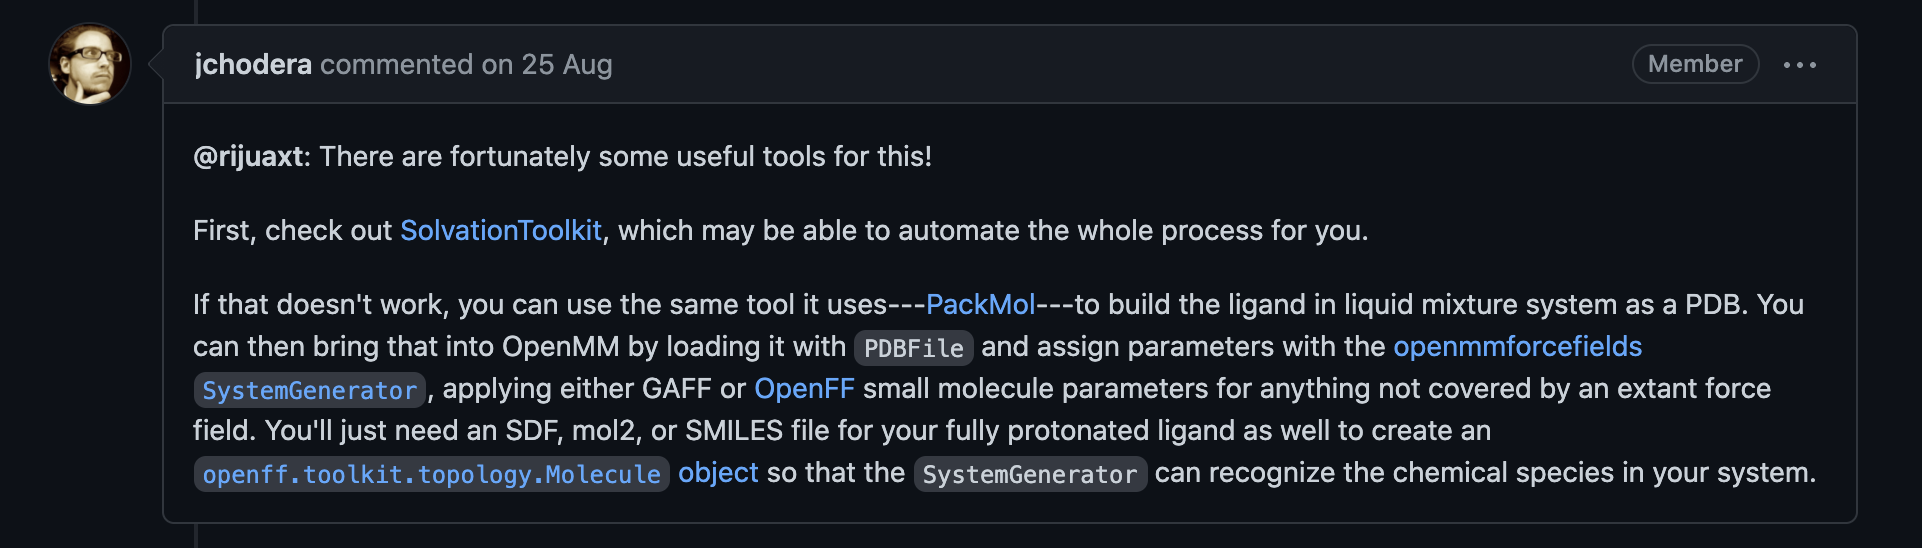

# VERY Simple OPLS applying with foyer here:
https://github.com/mosdef-hub/foyer/issues/431

```python
oplsaa = foyer.forcefields.load_OPLSAA()
benzene = mb.load("c1ccccc1", smiles=True)

out = oplsaa.apply(benzene)
```


## THIS is how you would add external forces e.g. from QM and let OpenMM drive the dynamics!
https://github.com/openmm/openmm-cookbook/blob/main/notebooks/cookbook/Applying%20a%20Constant%20External%20Force.ipynb

In [14]:
traj = mdtraj.load_pdb('/home/asod/Dropbox/HI/Benni/DMF_from_cmmtools/dmf_NPT.pdb')
nglview.show_mdtraj(traj)

NGLWidget(max_frame=999)

In [2]:
traj = mdtraj.load_pdb('./dmf_NPT_withLJ.pdb')
nglview.show_mdtraj(traj)

NGLWidget(max_frame=999)

<IPython.core.display.Javascript object>


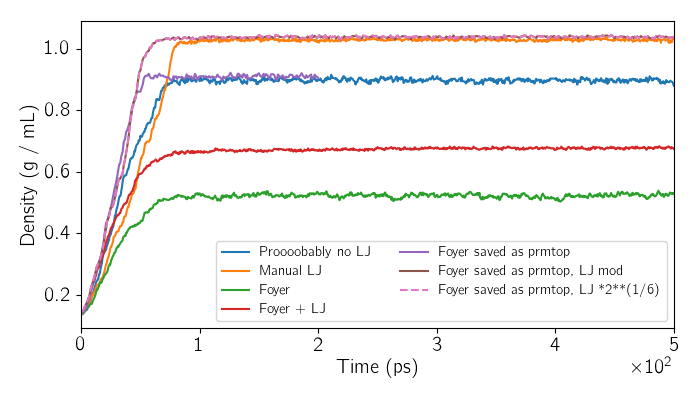

In [227]:
log = np.genfromtxt('/home/asod/Dropbox/HI/Benni/DMF_from_cmmtools/dmf_NPT.log', skip_header=1)
log_lj = np.genfromtxt('./dmf_NPT_withLJ.log', skip_header=1)
log_fy = np.genfromtxt('./dmf_foyer_NPT.log', skip_header=1)
log_fy_lj = np.genfromtxt('./dmf_foyer_manualLJ_NPT.log', skip_header=1)
log_fy_prmtop = np.genfromtxt('./box_foyer_prmtop.log', skip_header=1)
log_fy_prmtop_vasu = np.genfromtxt('./box_foyer_prmtop_vasu-lj.log', skip_header=1)
log_fy_prmtop_vasu_conv = np.genfromtxt('./box_foyer_prmtop_vasu-lj-conv.log', skip_header=1)




dt = 2e-3
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(log[:, 0] * dt, log[:, 3], label='Proooobably no LJ')
ax.plot(log_lj[:, 0] * dt, log_lj[:, 4], label='Manual LJ')
ax.plot(log_fy[:, 0] * dt, log_fy[:, 4], label='Foyer')
ax.plot(log_fy_lj[:, 0] * dt, log_fy_lj[:, 4], label='Foyer + LJ')
ax.plot(log_fy_prmtop[:, 0] * dt, log_fy_prmtop[:, 4], label='Foyer saved as prmtop')
ax.plot(log_fy_prmtop_vasu[:, 0] * dt, log_fy_prmtop_vasu[:, 4], label='Foyer saved as prmtop, LJ mod')
ax.plot(log_fy_prmtop_vasu[:, 0] * dt, log_fy_prmtop_vasu[:, 4], '--', label='Foyer saved as prmtop, LJ *2**(1/6) ')


ax.legend(loc='best', fontsize=10, ncol=2)


#ax2 = ax.twinx()
#ax2.plot(log[:, 0] * dt, log[:, 2], 'C3')
ax.set_ylabel('Density (g / mL)')
#ax2.set_ylabel('Temperature (K)')

for ax in (ax, ax2):
    ax.set_xlabel('Time (ps)')
    ax.set_xlim([0, 500])

fig.tight_layout()

Feck. Which one is right?  Any of them? 
Do some RDFs. If i can find a fkn box

In [38]:
from MDAnalysis.analysis.rdf import InterRDF
import MDAnalysis as mda 

u = mda.Universe('./wut.prmtop', './box_foyer_prmtop.dcd')
nglview.show_mdanalysis(u)


NGLWidget(max_frame=199)

Seems like box sizes are NEITHER saved in the pdb or in the dcd all of a sudden. FFS. Makes it kinda impossible to get RDFs.

In [72]:
mol1 = u.atoms[:12]
mol1.type_indices

v = nglview.show_mdanalysis(mol1)
v.add_label(labelType='atomindex', color='black')
v

NGLWidget(max_frame=199)

In [94]:
OA = u.select_atoms('name O')

# HA is idx 10 but bynum is 1-indexed
idx = list(range(11, 512*12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
HA = u.select_atoms(selstr)

# CA ditto:
idx = list(range(10, 512*12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
CA = u.select_atoms(selstr)


v = nglview.show_mdanalysis(HA+OA+CA)
v

NGLWidget(max_frame=199)

10.1016/j.molliq.2015.03.004  has: 

RDFs between O_A and and C_A 

as well as

O_A and H_A:

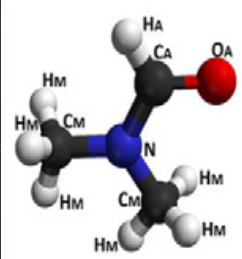



In [127]:
start_frame = 75
r_max = np.min(np.concatenate([frame.dimensions[:3] for frame in u.trajectory[start_frame:]])) / 2

dr = 0.1
r_range = (0.0, r_max)
nbins = len(np.arange(r_range[0], r_range[1], dr))

rdf = InterRDF(OA, CA, nbins=nbins, range=r_range)
rdf.run(start=start_frame, stop=-1)

In [219]:
start_frame = 100
u_vasu = mda.Universe('./wut.prmtop', './box_foyer_prmtop_vasu-lj.dcd')
OA = u_vasu.select_atoms('name O')

# HA is idx 10 but bynum is 1-indexed
idx = list(range(11, 512*12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
HA = u_vasu.select_atoms(selstr)

# CA ditto:
idx = list(range(10, 512*12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
CA = u_vasu.select_atoms(selstr)
rdf_vasu = InterRDF(OA, CA, nbins=nbins, range=r_range)
rdf_vasu.run(start=start_frame, stop=-1)


In [252]:
# the one with the custom LJ potential so we can get proper OPLS combining rules

start_frame = 100
u_vasu_opls_custompot = mda.Universe('./wut.prmtop', './box_foyer_prmtop_custom-lj-pot.dcd')  
OA = u_vasu_opls_custompot.select_atoms('name O')

# HA is idx 10 but bynum is 1-indexed
idx = list(range(11, 512*12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
HA = u_vasu_opls_custompot.select_atoms(selstr)

# CA ditto:
idx = list(range(10, 512*12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
CA = u_vasu_opls_custompot.select_atoms(selstr)
rdf_vasu_opls_custompot = InterRDF(OA, CA, nbins=nbins, range=r_range)
rdf_vasu_opls_custompot.run(start=start_frame, stop=-1)


In [ ]:
start_frame = 100
u_vasu_opls = mda.Universe('./wut.prmtop', './box_foyer_prmtop_vasu-lj-conv.dcd')
OA = u_vasu_opls.select_atoms('name O')

# HA is idx 10 but bynum is 1-indexed
idx = list(range(11, 512*12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
HA = u_vasu_opls.select_atoms(selstr)

# CA ditto:
idx = list(range(10, 512*12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
CA = u_vasu_opls.select_atoms(selstr)
rdf_vasu_opls = InterRDF(OA, CA, nbins=nbins, range=r_range)
rdf_vasu_opls.run(start=start_frame, stop=-1)


<IPython.core.display.Javascript object>


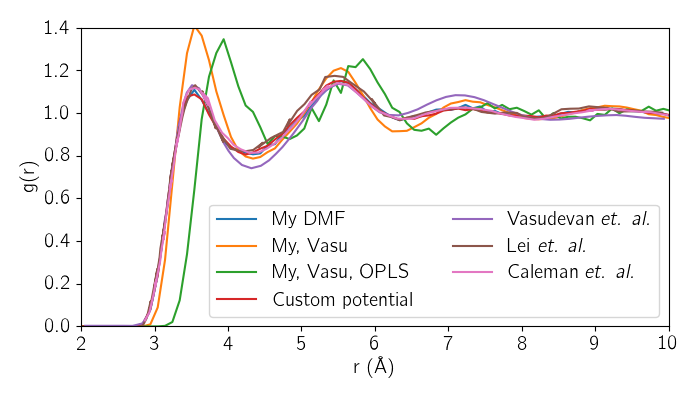

<IPython.core.display.Javascript object>


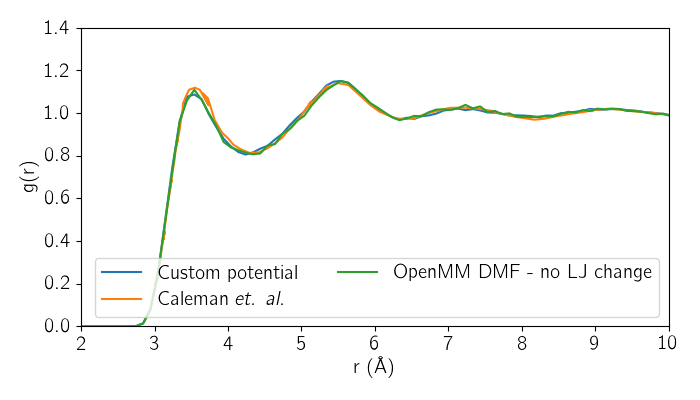

In [256]:
vasu = np.genfromtxt('/home/asod/Dropbox/HI/Benni/DMF/dmf_OA-CA-vasuvedan.csv', delimiter=',')
lei = np.genfromtxt('/home/asod/Dropbox/HI/Benni/DMF/dmf_OA-CA-lei.csv', delimiter=',')
cale = np.genfromtxt('/home/asod/Dropbox/HI/Benni/DMF/dmf_OA-CA-caleman.csv', delimiter=',')



fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(rdf.results.bins, rdf.results.rdf, label='My DMF')
ax.plot(rdf_vasu.results.bins, rdf_vasu.results.rdf, label='My, Vasu')
ax.plot(rdf_vasu_opls.results.bins, rdf_vasu_opls.results.rdf, label='My, Vasu, OPLS')
ax.plot(rdf_vasu_opls_custompot.results.bins, rdf_vasu_opls_custompot.results.rdf, label='Custom potential')
ax.plot(vasu[:, 0], vasu[:, 1], label='Vasudevan \emph{et. al.}')
ax.plot(lei[:, 0], lei[:, 1], label='Lei \emph{et. al.}')
ax.plot(cale[:, 0], cale[:, 1], label='Caleman \emph{et. al.}')

ax.set_ylim([0, 1.4])
ax.set_xlim([2, 10])
ax.set_ylabel('g(r)')
ax.set_xlabel('r (Å)')
ax.legend(loc='lower right', ncol=2)
fig.tight_layout()


fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(rdf_vasu_opls_custompot.results.bins, rdf_vasu_opls_custompot.results.rdf, label='Custom potential')
ax.plot(cale[:, 0], cale[:, 1], label='Caleman \emph{et. al.}')
ax.plot(rdf.results.bins, rdf.results.rdf, label='OpenMM DMF - no LJ change')
ax.set_ylim([0, 1.4])
ax.set_xlim([2, 10])
ax.set_ylabel('g(r)')
ax.set_xlabel('r (Å)')
ax.legend(loc='lower right', ncol=2)
fig.tight_layout()

In [160]:
u.atoms.charges[:12]
cdict = {'CA': '0.5', 'CM': '-0.11', 'HA': '0.0', 'HM': '0.06', 'OA':'-0.5', 'N':'-0.14'}
cdict = dict((v,k) for k,v in cdict.items())
order = [cdict[str(round(x, 2))] for x in u.atoms.charges[:12]]

In [173]:
v = nglview.show_mdanalysis(mol1)
for a, atom in enumerate(mol1):
    v.shape.add('text', atom.position.tolist(), [0, 0.0, 0], 1.0, order[a])
    #v.children[0].shape.add('text', p.tolist(), [0, 0.5, 1], 1.0, f'{i:d}') 
v

NGLWidget(max_frame=199)

In [214]:
import openmm.unit as ou
print(order)

num_mols = 512
#                #eps    sig
vasu_lj = {'CA': (0.439 * ou.kilojoule_per_mole, 3.75 * ou.angstrom),
           'CM': (0.276 * ou.kilojoule_per_mole, 3.50 * ou.angstrom),
           'HA': (0.126 * ou.kilojoule_per_mole, 2.50 * ou.angstrom),
           'HM': (0.126 * ou.kilojoule_per_mole, 2.50 * ou.angstrom),
           'OA': (0.878 * ou.kilojoule_per_mole, 2.96 * ou.angstrom),
           'N' : (0.711 * ou.kilojoule_per_mole, 3.25 * ou.angstrom)}

epsilons = np.tile(np.array([vasu_lj[typ][0] for typ in order]), num_mols)
sigmas = np.tile(np.array([vasu_lj[typ][1] for typ in order]), num_mols)



['CM', 'HM', 'HM', 'HM', 'N', 'CM', 'HM', 'HM', 'HM', 'CA', 'HA', 'OA']


Quantity(value=0.35000000000000003, unit=nanometer)

In [213]:
import sys
sys.path.append('../../')
from cmm.md.cmmsystems import CMMSystem
['CM', 'HM', 'HM', 'HM', 'N', 'CM', 'HM', 'HM', 'HM', 'CA', 'HA', 'OA']
sys = CMMSystem('box_foyer_prmtop_vasu-lj', fpath='./')
sys.system_from_prmtop('wut.prmtop')


nbf = [force for force in sys.system.getForces() if isinstance(force, NonbondedForce)]
force = nbf[0]
for i in range(force.getNumParticles()):
    charge, sigma, epsilon = force.getParticleParameters(i)
    force.setParticleParameters(i, charge,
                                sigmas[i].in_units_of(ou.nanometer),
                                epsilons[i].in_units_of(ou.kilojoule_per_mole))
    print(f'SIG: OLD: {sigma._value:9.6f}, NEW: {sigmas[i].in_units_of(ou.nanometer)._value:9.6f} ' +
          f'EPS: OLD: {epsilon._value:9.6f}, NEW: {epsilons[i].in_units_of(ou.kilojoule_per_mole)._value:9.6f}' + 
          f' Charge: {charge._value:2.4f}')
            
scale_fac = 0.5
for i in range(force.getNumExceptions()):
    particle1, particle2, chargeProd, sigma, epsilon = force.getExceptionParameters(i)
    if chargeProd != 0 * u.elementary_charge**2: # Is it a 1-4 interaction?
        newChargeProd = chargeProd * scale_fac
        #print(i, chargeProd, newChargeProd)
        new_scaled_sig = np.sqrt(sigmas[particle1] * sigmas[particle2]) * scale_fac
        new_scaled_eps = np.sqrt(epsilons[particle1] * epsilons[particle2]) * scale_fac
        
        force.setExceptionParameters(i, particle1, particle2,
                                     newChargeProd, new_scaled_sig, new_scaled_eps)

SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711000 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439000 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS:

SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711000 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439000 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS:

SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711000 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439000 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS:

SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439000 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878000 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS:

SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878000 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711000 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS

SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711000 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439000 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878000 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276000 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.126000 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS

AttributeError: 'Universe' object has no attribute 'elementary_charge'

In [199]:
syms = [a for i, a in enumerate(sys.topology.atoms())]
atom = syms[0]
atom.


'1'

### Foyer attempt

In [4]:
import foyer
import mbuild as mb
oplsaa = foyer.forcefields.load_OPLSAA()

test = mb.load(box)
out = oplsaa.apply(test)

/opt/tljh/user/envs/py38/lib/python3.8/site-packages/foyer/forcefield.py:348: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 5120, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)


In [6]:
out.save('wut.top', overwrite=True)
out.save('wut.gro', overwrite=True)
out.save('wut.prmtop', overwrite=True)

In [7]:
# create single molecule top, because this one can make the system:
gro = GromacsGroFile('wut.gro')
top = GromacsTopFile('wut.top', periodicBoxVectors=gro.getPeriodicBoxVectors(),
        includeDir='/home/asod/Apps/gromacs/gromacs-2021.1/share/top/oplsaa.ff/')
box_system = top.createSystem(nonbondedMethod=app.PME, 
                              nonbondedCutoff=1.0 * u.nanometers, 
                              constraints=app.HBonds)
box_system.addForce(MonteCarloBarostat(1 * u.bar, 300 * u.kelvin))

7

In [8]:
integrator = LangevinIntegrator(300 * u.kelvin, 1 / u.picosecond, 2 * u.femtoseconds)
simulation = app.Simulation(top.topology, box_system, integrator)
simulation.context.setPositions(gro.getPositions())

In [9]:
step = 250
tag = 'dmf_foyer_NPT'
simulation.minimizeEnergy()
simulation.reporters.append(app.PDBReporter(f'{tag}.pdb', step))
simulation.reporters.append(app.DCDReporter(f'{tag}.dcd', step))
olist = [f'{tag}.log']
olist = [stdout] + olist
for out in olist:
    simulation.reporters.append(app.StateDataReporter(out, step, step=True, speed=True,
                                     potentialEnergy=True, temperature=True, volume=True,
                                     density=True, separator='\t'))

simulation.step(250000)


#"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Box Volume (nm^3)"	"Density (g/mL)"	"Speed (ns/day)"
250	5698558.102951389	127.04092874347644	451.5569992338521	0.13762233312222463	0
500	5702376.743263688	193.9922692314122	450.9195375592786	0.13781688881481152	14.4
750	5704828.442405981	238.85304623768985	443.5156843821123	0.14011754253699107	14.4
1000	5706357.9667734895	265.4138770478288	443.05600293194357	0.14026291791780357	14.4
1250	5707471.020533234	276.9623829355422	430.3685000432494	0.14439794679672932	14.3
1500	5708040.70076496	287.4956268924254	426.8635893547102	0.1455835759292024	14.2
1750	5708352.451909739	288.5558998549744	417.36982321749093	0.1488951148723802	14
2000	5708164.148502169	293.6347424193399	412.38721529081727	0.15069411821704723	13.9
2250	5708293.925442686	299.0769742757829	402.0539270575223	0.15456714532561266	13.8
2500	5708618.4482611595	300.1157848387522	397.514851983431	0.15633209039148954	13.8
2750	5708391.469496102	303.80898085208736	389.0151326162

24250	5702559.119445938	302.43313207476444	143.0636783602303	0.43438228685659586	9.4
24500	5702803.183270716	297.9939315497771	143.54932408969665	0.4329127160041694	9.38
24750	5702409.61158282	297.8423485866484	143.23644731987395	0.43385834356428393	9.36
25000	5702797.343924465	298.8882222867753	142.23806976445115	0.43690362133812327	9.34
25250	5702505.821740327	303.9802501012679	140.8425482546119	0.4412326285086112	9.32
25500	5702290.891507391	299.3704521320145	140.74706541998592	0.4415319608035601	9.3
25750	5702562.911556797	298.20858360521896	141.26561649888205	0.4399112063672275	9.28
26000	5702434.256755374	302.5571784936731	140.1619932820052	0.44337502854428773	9.26
26250	5702570.492129849	297.9787852583302	137.60055310477125	0.4516284736509427	9.24
26500	5702376.042272102	299.6601656800985	135.78734513880926	0.4576592001906068	9.22
26750	5702035.939625475	303.59014380144555	133.10943581165452	0.4668664350750123	9.2
27000	5702156.317227016	300.17229066536805	133.10943581165452	0.4

48500	5701331.150112602	301.34913899904876	117.53015116239673	0.5287522151346992	8.07
48750	5701213.747612601	302.5005257002685	117.49528784780036	0.5289091069995344	8.06
49000	5701315.443606937	298.00118513143093	117.09213479520716	0.5307301628834683	8.05
49250	5701160.871009581	298.6279446808428	118.14126006810709	0.5260171402980451	8.04
49500	5700975.588478876	300.9514002158133	118.14126006810709	0.5260171402980451	8.04
49750	5701184.712708752	299.7337411210079	117.26011480474361	0.5299698697695574	8.03
50000	5701027.835235747	306.2641993266637	117.34938376133513	0.5295667159072799	8.02
50250	5701165.849369433	299.27215586321	117.5510271126268	0.5286583137439729	8.02
50500	5701589.852642146	296.1335870452665	119.07559686879459	0.5218897020579966	8.01
50750	5701005.032806164	299.83519512340297	118.34466051207833	0.5251130680787313	8
51000	5701212.188701482	305.3044311508346	118.3281712812606	0.525186243472986	8
51250	5701432.725156534	299.77052257066003	117.73015216593537	0.527853966

72750	5701165.603547607	299.3191433087231	117.0337373925795	0.5309949862044957	7.64
73000	5701165.7942167455	298.48813208654974	119.28766355526501	0.520961899328696	7.63
73250	5701199.314740458	300.49730032132373	119.39069179627934	0.5205123350677324	7.63
73500	5700931.592690033	304.744471740715	118.43133619022048	0.5247287565211556	7.63
73750	5700986.907938393	304.73389735925986	119.72257847652482	0.5190694066484591	7.63
74000	5701119.889483322	295.7408486279777	119.16028814657852	0.5215187772606749	7.62
74250	5700782.963555876	298.62225882333786	117.12813817382353	0.5305670246376519	7.62
74500	5700759.504267627	299.7051697326455	116.70118550090046	0.532508110397506	7.62
74750	5700999.68345913	295.3238605269693	117.12279674192385	0.5305912213586076	7.62
75000	5701067.193091738	300.01791191267245	118.27665096456897	0.5254150101937645	7.61
75250	5701170.5450684605	296.4055605984756	118.04605927116545	0.5264413581946062	7.61
75500	5701256.130859408	302.0063650235224	118.13337469126488	0.

97000	5701195.618975088	301.5484043056194	117.90097389057402	0.5270891810436661	7.43
97250	5701229.9930750765	299.9305059311616	117.12432054724415	0.5305843182856828	7.43
97500	5701070.428130698	301.4085993630585	117.47879224217608	0.5289833729659581	7.43
97750	5700999.186312428	298.6435360447524	117.50153667435193	0.5288809791863608	7.42
98000	5701263.287846415	297.70539208397605	117.16465661308789	0.530401654975631	7.42
98250	5700908.701519355	297.40943353999796	118.17629060349698	0.5258612150954957	7.42
98500	5700988.529882105	297.71050786517395	117.4452043873519	0.5291346555732664	7.42
98750	5700840.466469702	300.59060013661735	117.52394346944382	0.5287801441787974	7.42
99000	5700873.810471452	299.06880566384376	117.58458086667513	0.5285074566255972	7.42
99250	5700877.413766598	302.0179982168241	117.31114468703863	0.5297393349798203	7.42
99500	5700940.914852494	302.36511697166685	116.12634573227251	0.5351440913804875	7.41
99750	5700840.3406186085	305.96381316719305	116.971216940716

121000	5701200.3467695555	301.68115028553837	118.58778353407524	0.5240365062930504	7.31
121250	5700992.803086721	299.48082646539376	118.23864576929088	0.5255838932178767	7.31
121500	5701138.198540144	297.5678751275187	118.40074051040132	0.5248643505466424	7.31
121750	5700725.683070842	297.2783035948917	119.07302518535656	0.5219009735873894	7.31
122000	5700827.188437748	295.447149539856	118.40275889667326	0.5248554032973584	7.31
122250	5701270.25089121	295.8967647794801	118.23762447215815	0.5255884330361076	7.31
122500	5701324.903428708	300.4846936105576	117.86373808676443	0.5272557003621104	7.31
122750	5701161.720542244	301.63867372846215	117.5534955660865	0.5286472126836661	7.3
123000	5700956.167057757	302.8388711043034	117.7889082191196	0.527590659526514	7.3
123250	5700976.0164302755	308.29142540617187	116.90903746750858	0.5315613670115495	7.3
123500	5700930.674619701	301.52990831251344	117.6426255114961	0.5282466920645233	7.3
123750	5701071.492767443	299.52773989309395	117.014313864

145000	5700554.505843657	295.77192743411337	117.51755204382368	0.5288089029378265	7.24
145250	5700514.520902483	299.7321473480898	117.9666341969627	0.5267958028579013	7.24
145500	5700983.481819287	300.4112287452931	118.1958628493569	0.5257741368785265	7.24
145750	5700817.824924873	299.1107088263749	117.65312313362782	0.5281995591536586	7.24
146000	5700978.28735327	302.96776018179446	118.42132093463063	0.5247731344471104	7.24
146250	5701495.967638788	295.20032985722275	119.85436577609734	0.5184986576819951	7.24
146500	5701050.426187031	300.0038159803085	119.8659303627018	0.518448633270447	7.23
146750	5701265.4197546495	304.3400396361169	119.00103315189281	0.5222167079248157	7.23
147000	5701222.904817792	304.6795089967071	118.02836320184964	0.5265202878900844	7.23
147250	5701109.694117166	299.2100658433719	118.12723588233312	0.5260795895887673	7.23
147500	5701075.331253614	302.50413310993804	117.61236533730514	0.5283826032578051	7.23
147750	5700951.761143347	302.78120145361885	117.462758

171750	5701339.036385902	293.9037081005815	118.78414731805702	0.5231702140003192	7.17
172000	5701145.626090677	300.94297145451225	118.67941416030592	0.5236319054313162	7.17
172250	5701176.208873544	304.1529306147921	119.54639076554314	0.5198344121832341	7.17
172500	5701112.67704628	293.8877355208197	118.62867055806781	0.5238558898105005	7.17
175500	5701468.2238082485	299.1000057267178	120.48871024938823	0.5157688852640768	7.16
175750	5701116.391860314	304.0112662117105	119.47284765141151	0.5201544032293695	7.16
176000	5701219.728751911	308.4854982855598	119.23828059726235	0.5211776575522016	7.16
176250	5701909.461537335	296.7376634234612	121.5550268814877	0.5112444081216162	7.16
176500	5701361.591328025	305.7548373391169	122.25263848739404	0.5083270884058774	7.16
176750	5701565.0768543985	303.25274102424703	121.54906241589407	0.511269495108069	7.16
177000	5701277.075414985	306.81854945599525	119.70628166111885	0.5191400727671093	7.16
177250	5701437.786500926	300.83707850986696	119.9829

198500	5701416.879709845	302.382662912244	121.00379265945821	0.5135733881261599	7.13
198750	5701275.619979652	305.0583699090796	120.38513552183352	0.5162126329206366	7.13
199000	5701542.604659074	297.477074552672	120.52753420096558	0.5156027474072017	7.13
199250	5701599.048282244	297.0513219586582	120.66365368631799	0.5150211010001917	7.13
199500	5701460.353137407	297.94632903548427	120.86010770810917	0.51418395160063	7.13
199750	5701508.688965476	295.1682620143712	121.74299071651225	0.5104550775899787	7.13
200000	5701880.604019115	295.4167945816204	121.80276610305799	0.5102045689147378	7.13
200250	5701477.168799547	302.467315732732	122.51449308945165	0.5072406227633806	7.13
200500	5701519.249048572	301.7282570358006	120.95743748187438	0.5137702076529667	7.13
200750	5701555.657317383	303.19802350540243	121.10187101004064	0.5131574537529721	7.13
201000	5701747.374746802	300.5962542990511	120.66832815955709	0.5150011500122984	7.13
201250	5701839.153480627	302.07862651449904	122.973765446

222500	5701128.641113138	302.9862497429759	119.70712666788826	0.5191364081826525	7.11
222750	5701222.049938046	298.48498913212893	119.18860435909606	0.5213948775253924	7.11
223000	5701202.799417508	301.3128176710027	119.328725553541	0.5207826320440346	7.11
223250	5701392.97038329	300.3808783971594	118.10874936827062	0.526161932156807	7.11
223500	5700940.47770296	303.1436536712719	116.93538842806329	0.5314415816086632	7.11
223750	5700652.351077971	299.28911884370024	118.09156662781537	0.5262384905781731	7.11
224000	5700944.2203807095	298.02323441494957	118.68424761908162	0.5236105803331729	7.11
224250	5700949.581768355	300.831182827712	119.4155589775767	0.5204039432072877	7.11
224500	5700923.068371165	298.3691310157401	119.6139668895004	0.5195407308048094	7.11
224750	5701041.31834513	294.70969566736323	118.7938445888257	0.5231275070465974	7.11
225000	5701063.398531446	300.2583098894028	119.70569275983166	0.5191426267162995	7.11
225250	5701083.192583401	297.50863431912813	119.78329158369

246500	5701078.282069853	296.75623815314293	117.48211388112634	0.5289684167167246	7.08
246750	5701244.832196382	302.09540402654017	118.00082453048816	0.5266431655837874	7.08
247000	5701291.150257813	300.1104610157883	117.670459391447	0.5281217401004755	7.08
247250	5701355.91167748	300.1208977971842	118.81600216785209	0.5230299508347508	7.08
247500	5701353.875433747	298.28065186942933	119.132517378742	0.5216403475691378	7.08
247750	5701038.932159282	300.29583269553655	118.66331421290904	0.5237029505238008	7.08
248000	5700794.290840719	300.5923335128626	118.26607168141234	0.5254620102681608	7.08
248250	5700857.719706869	302.0934762946953	116.64649673016642	0.5327577725372178	7.08
248500	5700760.100086456	300.3202736610607	116.9959760325574	0.5311663689607575	7.08
248750	5700879.8757456485	298.90323831995084	117.17627369497178	0.5303490699320645	7.08
249000	5700971.387667689	298.38825085572273	117.11887689689667	0.5306089796860064	7.08
249250	5700646.500370764	306.3725536932479	117.774448

In [33]:
import MDAnalysis as mda
u = mda.Universe('./wut.prmtop', './box_foyer_prmtop.dcd')
nglview.show_mdanalysis(u)

NGLWidget(max_frame=199)

In [18]:
frame = u.trajectory[-1]
frame.dimensions

array([45.16519, 45.16519, 45.16519, 90.     , 90.     , 90.     ],
      dtype=float32)

### Weyhey we got the boxvectors in there now, but it looks like the LJs are STILL lost

Try again setting them manually. I somehow doubt this will fix it, but..


## YOU NEED TO COMBINE MANUALLY  IN THE getExceptionParameters BELOW!

`particle1` and `particle2` are just numbers.. so you need to generate a list of epsilons and sigmas for the entire array.. I already have that? Yes i do: 

In [6]:
from openmm import NonbondedForce

# create single molecule top, because this one can make the system:
gro = GromacsGroFile('wut.gro')  # the gro and top made above
top = GromacsTopFile('wut.top', periodicBoxVectors=gro.getPeriodicBoxVectors(),
        includeDir='/home/asod/Apps/gromacs/gromacs-2021.1/share/top/oplsaa.ff/')
manual_lj_system = top.createSystem(nonbondedMethod=app.PME, 
                              nonbondedCutoff=1.0 * u.nanometers, 
                              constraints=app.HBonds)
manual_lj_system.addForce(MonteCarloBarostat(1 * u.bar, 300 * u.kelvin))

nbf = [force for force in manual_lj_system.getForces() if isinstance(force, NonbondedForce)]
force = nbf[0]
for i in range(force.getNumParticles()):
    charge, sigma, epsilon = force.getParticleParameters(i)
    force.setParticleParameters(i, charge,
                                sigmas[i].in_units_of(u.nanometer),
                                epsilons[i].in_units_of(u.kilojoule_per_mole))
    print(f'SIG: OLD: {sigma._value:9.6f}, NEW: {sigmas[i].in_units_of(u.nanometer)._value:9.6f} ' +
          f'EPS: OLD: {epsilon._value:9.6f}, NEW: {epsilons[i].in_units_of(u.kilojoule_per_mole)._value:9.6f}' + 
          f' Charge: {charge._value:2.4f}')
            
scale_fac = 0.5
for i in range(force.getNumExceptions()):
    particle1, particle2, chargeProd, sigma, epsilon = force.getExceptionParameters(i)
    if chargeProd != 0 * u.elementary_charge**2: # Is it a 1-4 interaction?
        newChargeProd = chargeProd * scale_fac
        #print(i, chargeProd, newChargeProd)
        new_scaled_sig = np.sqrt(sigmas[particle1] * sigmas[particle2]) * scale_fac
        new_scaled_eps = np.sqrt(epsilons[particle1] * epsilons[particle2]) * scale_fac
        
        force.setExceptionParameters(i, particle1, particle2,
                                     newChargeProd, new_scaled_sig, new_scaled_eps)


SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711280 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439320 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.242000 EPS: OLD:  0.000000, NEW:  0.062760 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS:

SIG: OLD:  1.000000, NEW:  0.242000 EPS: OLD:  0.000000, NEW:  0.062760 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878640 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711280 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS

SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711280 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439320 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.242000 EPS: OLD:  0.000000, NEW:  0.062760 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878640 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS:

SIG: OLD:  1.000000, NEW:  0.325000 EPS: OLD:  0.000000, NEW:  0.711280 Charge: -0.1400
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.375000 EPS: OLD:  0.000000, NEW:  0.439320 Charge: 0.5000
SIG: OLD:  1.000000, NEW:  0.242000 EPS: OLD:  0.000000, NEW:  0.062760 Charge: 0.0000
SIG: OLD:  1.000000, NEW:  0.296000 EPS: OLD:  0.000000, NEW:  0.878640 Charge: -0.5000
SIG: OLD:  1.000000, NEW:  0.350000 EPS: OLD:  0.000000, NEW:  0.276144 Charge: -0.1100
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS: OLD:  0.000000, NEW:  0.125520 Charge: 0.0600
SIG: OLD:  1.000000, NEW:  0.250000 EPS

In [7]:
integrator = LangevinIntegrator(300 * u.kelvin, 1 / u.picosecond, 2 * u.femtoseconds)
simulation = app.Simulation(top.topology, manual_lj_system, integrator)
simulation.context.setPositions(gro.getPositions())

In [10]:
simulation.system.getForces()[0].getParticleParameters(0)

[Quantity(value=-0.11, unit=elementary charge),
 Quantity(value=0.35, unit=nanometer),
 Quantity(value=0.276144, unit=kilojoule/mole)]

In [ ]:
step = 250
tag = 'dmf_foyer_manualLJ_NPT'
simulation.minimizeEnergy()
simulation.reporters.append(app.PDBReporter(f'{tag}.pdb', step))
simulation.reporters.append(app.DCDReporter(f'{tag}.dcd', step))
olist = [f'{tag}.log']
olist = [stdout] + olist
for out in olist:
    simulation.reporters.append(app.StateDataReporter(out, step, step=True, speed=True,
                                     potentialEnergy=True, temperature=True, volume=True,
                                     density=True, separator='\t'))

simulation.step(250000)


#"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Box Volume (nm^3)"	"Density (g/mL)"	"Speed (ns/day)"
250	5682391.473647973	126.91684705677473	441.1587847502802	0.14086612331070408	0
500	5686516.758363031	203.07737429404065	439.55060472676644	0.14138150898657845	12.9
750	5688933.266102553	239.78889394613225	426.6104010383865	0.14566997809001278	13
1000	5690439.94075063	262.0140335292584	419.8824913418149	0.14800409413033447	13
1250	5690258.145864947	285.9746780638304	401.01749548871106	0.15496662482642914	12.9
1500	5690835.98526611	292.2495574153367	398.15729048694317	0.1560798439637544	12.8
1750	5691225.160939434	293.89697690037445	389.1520427059831	0.1596916396483761	12.7
2000	5691030.339555694	298.82774410676086	385.08426680853563	0.16137851667445963	12.5
2250	5690443.181271237	304.2566210431121	375.6879128875015	0.16541476486320236	12.4
2500	5690182.122547731	301.64023917671994	357.822121208968	0.1736738007205012	12.3
2750	5689637.634405791	306.02984190931966	349.95948809181

24250	5675711.417945441	296.7978956220447	105.13319156136552	0.591100934436677	7.49
24500	5675540.780666259	302.1864876341599	104.89841437237595	0.5924239002472327	7.47
24750	5675774.816017147	297.40237755985083	104.89841437237595	0.5924239002472327	7.45
25000	5675711.869399181	303.9641698237387	104.58961751248212	0.5941730092359959	7.43
25250	5675761.484385266	304.71886043919665	104.5914355019848	0.5941626814277162	7.41
25500	5675547.869251266	304.6796164719474	104.51863325685635	0.5945765442561095	7.39
25750	5675767.728617621	302.36363149495435	104.05417674230753	0.5972304977832378	7.37
26000	5675980.250972241	300.42627513899475	103.67638629993013	0.599406769372277	7.36
26250	5675500.876174738	301.92319313420677	102.94210492893076	0.603682310704027	7.34
26500	5675560.923236651	300.5129663521061	102.8234260440529	0.6043790813351101	7.32
26750	5675085.783066879	301.00157357564626	101.75355814861292	0.6107337070362729	7.31
27000	5675189.504871134	294.80238448806995	101.83107154455953	0.

53000	5673840.76777352	302.02003841676304	93.4701950264777	0.664857153177325	6.39
53250	5673803.282154641	296.40265922741776	93.67458007058995	0.6634065263532912	6.39
53500	5673695.089653824	299.8344921615374	93.82773792182063	0.6623236278382132	6.38
53750	5673713.094097737	303.8486153172994	93.69874544633767	0.6632354304874241	6.38
54000	5673824.788754191	301.598836591911	93.58278738376573	0.6640572428922309	6.37
54250	5673760.206929047	300.55753728284304	93.19925973458926	0.6667899289029392	6.37
54500	5673844.790093219	303.23613620385913	93.41878855894274	0.6652230106048022	6.37
54750	5674109.194986835	301.49559734790154	93.22066912561631	0.6666367915520203	6.36
55000	5674031.754331062	301.21483053141753	93.29145259435556	0.6661309910399366	6.36
55250	5673419.82276384	304.70258533161336	93.02477040204124	0.6680406466326488	6.36
55500	5673962.137153331	297.53154301315607	93.10206400887246	0.6674860373268533	6.35
55750	5673154.446332197	306.508906031469	93.1721846913333	0.6669836923767

80000	5673534.581479432	296.3396412623113	92.79496509426465	0.6696950390476978	6.1
80250	5673884.814722835	300.8389371632456	93.01458766823255	0.6681137801082528	6.09
80500	5673598.775387773	297.25637243838617	93.12338244237176	0.6673332319161684	6.09
80750	5673360.002664085	301.7984127431116	93.04513490531257	0.6678944346254594	6.09
81000	5673659.876670187	299.8197014150436	92.53252290599089	0.671594438588574	6.09
81250	5673438.286804297	298.8936639000873	92.28439804940574	0.6734001530677319	6.09
81500	5672777.319861166	308.40152458328276	92.06077523070977	0.675035894673882	6.09
81750	5673071.888714971	299.18420380129214	92.10006326347715	0.6747479379514938	6.08
82000	5672938.230833743	299.37837052271544	92.23538749843809	0.6737579735682867	6.08
82250	5673014.935896634	293.04371888040777	92.20241945157446	0.6739988835637017	6.08
82500	5673088.100270204	298.43619782998013	92.37297967305825	0.6727543919464851	6.08
82750	5672881.122400694	295.9595286095941	92.12433902131698	0.67457013458

104500	5673354.914969946	303.52112163464506	92.31087485938217	0.6732070069414707	5.97
104750	5673466.192278875	299.33483523935325	92.59060109853647	0.6711731756239308	5.96
105000	5673052.2136677895	302.6850840960269	92.63701558468743	0.6708368936542637	5.96
105250	5673291.520196674	299.3021267158216	92.44987590656783	0.6721948208458165	5.96
105500	5673404.558869442	293.97799810220835	92.2903739607536	0.673356549607873	5.96
105750	5672530.956534273	304.9763576049834	92.04217062187772	0.6751723405951716	5.96
106000	5673158.703464003	300.34612098030954	91.84790619254784	0.6766003749933654	5.96
106250	5673209.508036532	301.0283019874135	92.24667297782075	0.6736755458614204	5.96
106500	5672755.653283816	296.4529629876418	92.42448508512581	0.6723794859662617	5.96
106750	5672834.011612585	296.9635318502118	92.50027142986082	0.6718285991123262	5.96
107000	5673057.460876825	297.05612851375696	92.80883119183206	0.6695949833026509	5.96
107250	5673086.56590491	301.17369369708143	92.46867360131291	

128750	5672508.679063586	301.1845633697257	91.6265036742581	0.6782352843361019	5.88
129000	5673411.199740226	300.00544199699704	92.11445767613978	0.674642497388664	5.88
129250	5673027.294516334	304.4573484549796	92.04592935188039	0.6751447696797445	5.88
129500	5672924.82772968	302.52585639817494	91.95007404816019	0.675848588655669	5.88
129750	5673147.506716541	302.9632336275404	91.95052059314304	0.6758453064904949	5.88
130000	5672943.680312817	300.5906542805716	91.96858462761652	0.6757125601514639	5.88
130250	5672747.818654221	301.46805955693014	91.68830560607103	0.6777781240633867	5.88
130500	5672826.352005046	297.2161008099937	91.53984689863991	0.6788773400620213	5.88
130750	5672542.374813462	298.6028178505021	91.32431609800247	0.6804795308354091	5.88
131000	5672701.914672936	293.868685088868	91.54976710499987	0.6788037778507838	5.88
131250	5672908.298242537	299.7934387229526	91.90949665959769	0.6761469709968635	5.88
131500	5672873.592497703	298.4058677309499	92.18162932312511	0.6741

153000	5672766.781108048	303.09401929907176	91.53293676440285	0.6789285908326854	5.83
153250	5672745.208770012	304.2879581551022	91.81368371231643	0.6768525698952749	5.83
153500	5673025.668305267	297.6146136398713	92.20387656158988	0.6739882322704998	5.82


### If the above doesn't work try again with manual OPLS LJ potential format:

In [ ]:
def OPLS_LJ(system):
    forces = {system.getForce(index).__class__.__name__: system.getForce(
        index) for index in range(system.getNumForces())}
    nonbonded_force = forces['NonbondedForce']
    lorentz = CustomNonbondedForce(
        '4*epsilon*((sigma/r)^12-(sigma/r)^6); sigma=sqrt(sigma1*sigma2); epsilon=sqrt(epsilon1*epsilon2)')
    lorentz.setNonbondedMethod(nonbonded_force.getNonbondedMethod())
    lorentz.addPerParticleParameter('sigma')
    lorentz.addPerParticleParameter('epsilon')
    lorentz.setCutoffDistance(nonbonded_force.getCutoffDistance())
    system.addForce(lorentz)
    LJset = {}
    for index in range(nonbonded_force.getNumParticles()):
        charge, sigma, epsilon = nonbonded_force.getParticleParameters(index)
        LJset[index] = (sigma, epsilon)
        lorentz.addParticle([sigma, epsilon])
        nonbonded_force.setParticleParameters(
            index, charge, sigma, epsilon * 0)
    for i in range(nonbonded_force.getNumExceptions()):
        (p1, p2, q, sig, eps) = nonbonded_force.getExceptionParameters(i)
        # ALL THE 12,13 and 14 interactions are EXCLUDED FROM CUSTOM NONBONDED
        # FORCE
        lorentz.addExclusion(p1, p2)
        if eps._value != 0.0:
            #print p1,p2,sig,eps
            sig14 = sqrt(LJset[p1][0] * LJset[p2][0])
            eps14 = sqrt(LJset[p1][1] * LJset[p2][1])
            nonbonded_force.setExceptionParameters(i, p1, p2, q, sig14, eps)
    return system




## Solvate:
1. De-serialize
2. Cut out overlapping molecules
3. Fix topology

Then update the ASE OpenMMcalc to work with QMMM

In [11]:
from openmm.openmm import XmlSerializer
with open('/home/asod/Dropbox/HI/Benni/DMF_from_cmmtools/dmf_foyer_NPT.xml', 'r') as f:
    system = XmlSerializer.deserialize(f.read())

FileNotFoundError: [Errno 2] No such file or directory: '/home/asod/Dropbox/HI/Benni/DMF_from_cmmtools/dmf_foyer_NPT.xml'

In [7]:
pmd_top = pmd.openmm.load_topology(box_top, system=system)

/opt/tljh/user/lib/python3.6/site-packages/parmed/openmm/topsystem.py:183: OpenMMWarning: Unsupported Force type CustomNonbondedForce
  warnings.warn('Unsupported Force type %s' % type(force).__name__, OpenMMWarning)
/opt/tljh/user/lib/python3.6/site-packages/parmed/openmm/topsystem.py:183: OpenMMWarning: Unsupported Force type CustomBondForce
  warnings.warn('Unsupported Force type %s' % type(force).__name__, OpenMMWarning)


In [16]:
pmd_top.save('plz.top')

In [30]:
nbf = system.getForces()[0]
nbf.getParticleParameters(6)

[Quantity(value=0.06, unit=elementary charge),
 Quantity(value=1.0, unit=nanometer),
 Quantity(value=0.0, unit=kilojoule/mole)]

In [33]:

atoms = [atom for atom in box_top.atoms()]


In [38]:
atoms[0].

AttributeError: 'Atom' object has no attribute 'type'

In [ ]:
### CHECK FFS HVAD DE HAR I AF LJ PARAMS!

box.topology.atoms_

In [236]:
nbf = sys.system.getForces()[-2]
?nbf.setNonbondedMethod()

Object `nbf.setNonbondedMethod()` not found.


In [239]:
nbf.getCutoffDistance()

Quantity(value=1.0, unit=nanometer)

In [243]:
from openmm.app.forcefield import CutoffPeriodic
type(CutoffPeriodic)

openmm.app.forcefield.CutoffPeriodic

In [246]:
type(NonbondedForce.CutoffPeriodic)

int

In [249]:
type(app.CutoffPeriodic)

openmm.app.forcefield.CutoffPeriodic

In [251]:
NonbondedForce.CutoffPeriodic

2